<a href="https://colab.research.google.com/github/jclarte/models/blob/master/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 8.8MB/s 
     |████████████████████████████████| 1.2MB 16.1MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 5.6MB 16.9MB/s 
     |████████████████████████████████| 901kB 27.0MB/s 
     |████████████████████████████████| 7.6MB 41.8MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
  Created wheel for boto3: filename=boto3-1.17.80-py2.py3-none-any.whl size=128919 sha256=e2497f1d7a91227f6d1dbf296f108ed6848ac6c83c565c3662c355cf285da6cf
  Stored in directory: /root/.cache/pip/wheels/dc/9f/b0/342fe7c9ff632bf49e3a90cd8cf481de74f3475691865158e7
Successfully built boto3
ERROR: botocore 1.20.80 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import os
import json
import time
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# Functions : preprocess() (create dataloaders from raw data) 
# load_models() (load tokenizers and models) training() (loop of one training step) evaluate()

In [ ]:
dataset = pd.read_csv("""/content/drive/My Drive/Colab Notebooks/\
reviews_allocine_classification.csv""")
dataset.head()

,review,sentiment
0,1ère avant-première pour moi\nTrès satisfaite ...,1
1,"une épopée transcendante, un chef-d'oeuvre mag...",1
2,"Scénario très bon , mais super Mega hyper mou ...",0
3,Les grands critiques vont nous trouver du geni...,0
4,"Du début à la fin, le film arrive à nous scotc...",1


In [ ]:
reviews = dataset['review'].values.tolist()
sentiments = dataset['sentiment'].values.tolist()

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

In [ ]:
def preprocess(raw_reviews, sentiments=None):
    """
    Cette fonction prends de la donnée brute en argument et retourne un 'dataloader' pytorch

    Args
        raw_reviews (array-like) : Une liste de reviews sous forme de 'str'
        
        sentiments : Une liste 'sentiments' (0 = negatif, 1 = positif) de la meme taille que
                     'raw_review'
    
    Returns
        inputs_ids, attention_masks, sentiments(optionel) : Objet  de PyTorch qui contient 
                    les versions tokenisees et encodees des donnees brutes
    """

    

    encoded_batch = TOKENIZER.batch_encode_plus(raw_reviews,
                                                add_special_tokens=False,
                                                pad_to_max_length=True,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if sentiments:
        sentiments = torch.tensor(sentiments)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], sentiments
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

In [ ]:
# Split train-validation
split_border = int(len(sentiments)*0.8)
reviews_train, reviews_validation = reviews[:split_border], reviews[split_border:]
sentiments_train, sentiments_validation = sentiments[:split_border], sentiments[split_border:]

In [ ]:
input_ids, attention_mask, sentiments_train = preprocess(reviews_train, sentiments_train)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_train)

input_ids, attention_mask, sentiments_validation = preprocess(reviews_validation, sentiments_validation)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_validation)

In [ ]:
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/sentiments.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Enable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 2)

Loading trained model...



Trained model loaded!


In [ ]:
def predict(reviews, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask = preprocess(reviews)
        retour = model(input_ids, attention_mask=attention_mask)
        print(retour)
        return torch.argmax(retour[0], dim=1)

In [ ]:
def evaluate(reviews, sentiments, metric='report'):
    predictions = predict(reviews)
    if metric == 'report':
        return metrics.classification_report(sentiments, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(sentiments, predictions)

In [ ]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )

In [ ]:
# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 20

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device("cpu")

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        sentiment = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        loss, logits = model(input_id, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=sentiment)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/sentiments.pt")
    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break

print("Model saved!")
with open('/content/drive/MyDrive/Colab Notebooks/metrics.json', 'w+') as outfile:
    json.dump(training_stats, outfile)
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/sentiments.pt")


########## Epoch 0 / 20 ##########
Training...


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch 40  of  226    Elapsed: 0:12:55.
  Batch 80  of  226    Elapsed: 0:25:46.
  Batch 120  of  226    Elapsed: 0:38:37.
  Batch 160  of  226    Elapsed: 0:51:29.
  Batch 200  of  226    Elapsed: 1:04:19.

  Average training loss: 0.19
  Training epoch took: 4350.992983341217

########## Epoch 1 / 20 ##########
Training...
  Batch 40  of  226    Elapsed: 0:12:50.
  Batch 80  of  226    Elapsed: 0:25:41.
  Batch 120  of  226    Elapsed: 0:38:31.
  Batch 160  of  226    Elapsed: 0:51:28.
  Batch 200  of  226    Elapsed: 1:05:08.
Model saved!

  Average training loss: 0.05
  Training epoch took: 4424.071446895599

########## Epoch 2 / 20 ##########
Training...
  Batch 40  of  226    Elapsed: 0:12:51.
  Batch 80  of  226    Elapsed: 0:25:43.
  Batch 120  of  226    Elapsed: 0:38:38.
  Batch 160  of  226    Elapsed: 0:51:29.
  Batch 200  of  226    Elapsed: 1:04:22.
Model saved!

  Average training loss: 0.03
  Training epoch took: 4357.899804830551

########## Epoch 3 / 20 ##########
Tr

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       482
           1       0.98      0.99      0.99      1322

    accuracy                           0.98      1804
   macro avg       0.97      0.97      0.97      1804
weighted avg       0.98      0.98      0.98      1804



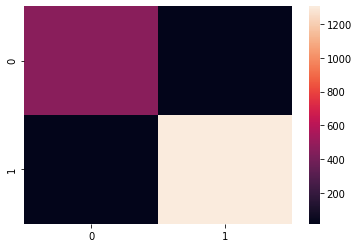

In [ ]:
# Evaluation with the confusion matrix
import seaborn
confusion_matrix = evaluate(reviews_validation, sentiments_validation, 'matrix')
report = evaluate(reviews_validation, sentiments_validation, 'report')
print(report)
seaborn.heatmap(confusion_matrix)
# precision    recall  f1-score   support

#            0       0.96      0.96      0.96       482
#            1       0.98      0.99      0.99      1322

#     accuracy                           0.98      1804
#    macro avg       0.97      0.97      0.97      1804
# weighted avg       0.98      0.98      0.98      1804

In [ ]:
import seaborn
confusion_matrix = evaluate(reviews, sentiments, 'matrix')
report = evaluate(reviews, sentiments, 'report')
print(report)
seaborn.heatmap(confusion_matrix)

NameError: ignored

In [ ]:
predict(['ce film est nul'])

(tensor([[ 3.5764, -4.2173]]),)


tensor([0])